In [32]:
from plot_data import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h_transport_materials as htm
from labellines import labelLines

htm.ureg.define('fraction = [] = frac')
htm.ureg.define('ppm = 1e-6 fraction')

MOLAR_VOL_RT = 24.45 * htm.ureg.L * htm.ureg.mol**-1
MOLAR_MASS_H2 = 2.016 * htm.ureg.g * htm.ureg.mol**-1

def downstream_flux(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up * permeability / L * (2*summation + 1)

def downstream_flux_metal(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum(
        (-1) ** n_array * np.exp(-((np.pi * n_array) ** 2) * D / L**2 * t), axis=0
    )
    return P_up**0.5 * permeability / L * (2 * summation + 1)


def sweep_gas_concentration(flux, area, gas_flow):
    return flux*area/gas_flow*MOLAR_MASS_H2

def concentration_to_ppm(concentration, molar_mass_species, molar_volume_gas):
    return (concentration * molar_volume_gas / molar_mass_species)


Located 'Sample statistics:' at line 4707
[-0.03722222222222222 0.01138888888888889 0.10805555555555556 0.15666666666666668 0.255 0.4502777777777778 0.49916666666666665 0.5472222222222223 0.5958333333333333 0.645 0.6936111111111111 0.7419444444444444 0.7911111111111111 0.8397222222222223 0.8880555555555556 0.9366666666666666 0.985 1.033611111111111 1.0827777777777778 1.1311111111111112 1.1791666666666667 1.2277777777777779 1.2763888888888888 1.3247222222222221 1.3733333333333333 1.4222222222222223 1.471111111111111 1.5197222222222222 1.5683333333333334 1.6169444444444445 1.6655555555555555 1.7138888888888888 1.7627777777777778 1.8108333333333333 1.8594444444444445 1.9080555555555556 1.956388888888889 2.004722222222222 2.0530555555555554 2.102222222222222 2.1508333333333334 2.1991666666666667 2.247777777777778 2.2969444444444442 2.345 2.3938888888888887 2.4419444444444443 2.4905555555555554 2.5391666666666666 2.5880555555555556 2.636388888888889 2.685 2.7330555555555556 2.78222222222222

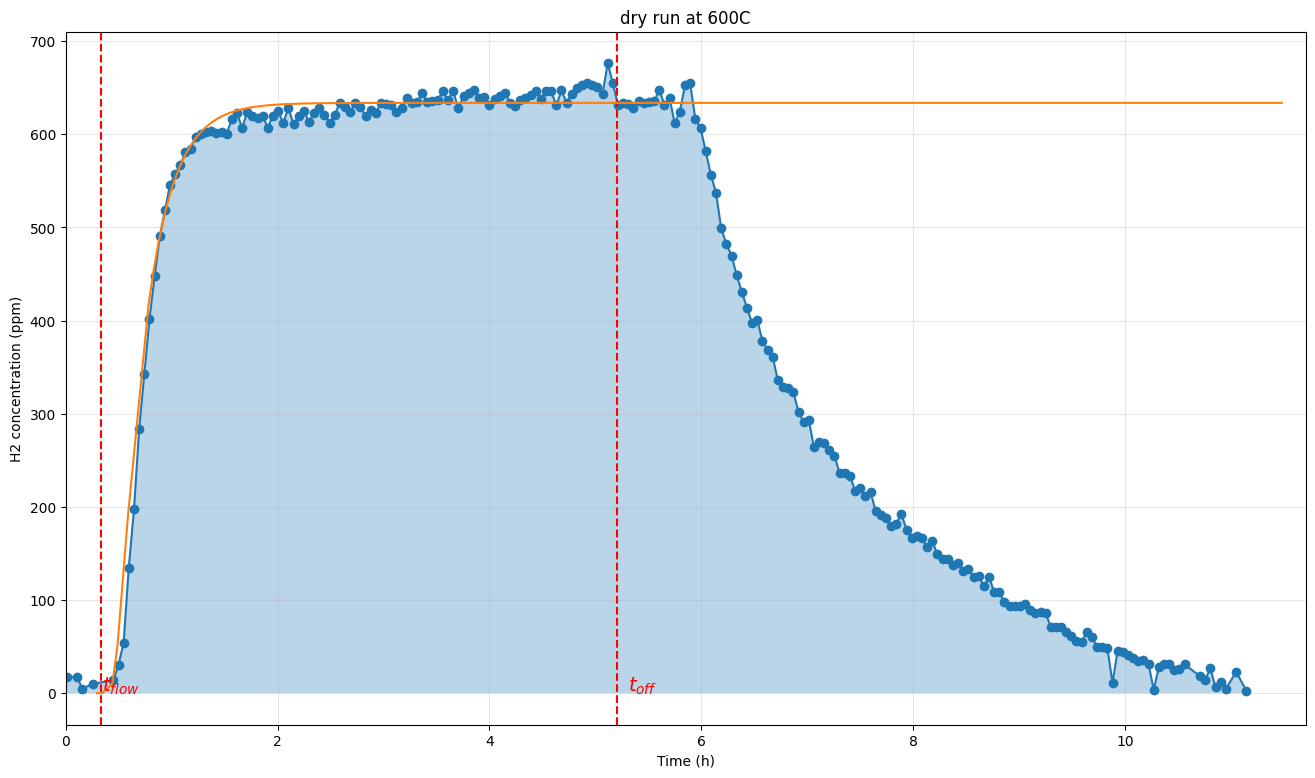

In [72]:
#Fitting the 6/28 dry run to a curve

filename = "data/dry_run_6-28.csv"
t_start = "2024-06-28 11:30:00-04:00"
title = "dry run at 600C"
vlines = {("2024-06-28 11:50:00-04:00","flow"),
          ("2024-06-28 16:42:00-04:00", "off")}

#plot_data(filename, t_start, title,vlines);

#plotting the fitted curve
t_array = plot_data(filename, t_start, title, vlines) * htm.ureg.h
print(t_array)
P_up = 1.3095 * htm.ureg.psi
permeability = 2.33e13 * htm.ureg.particle * htm.ureg.meter**-1 * htm.ureg.pascal**-0.5 * htm.ureg.second**-1
diffusivity = 4.56e-10 * htm.ureg.meter**2 * htm.ureg.second**-1
solubility = permeability/diffusivity
print(solubility)
L = 0.08*htm.ureg.inches
flux = downstream_flux_metal(t_array, P_up, permeability, L, diffusivity)
sweep_rate = 20 * htm.ureg.cm**3 * htm.ureg.min**-1
diam = 3.07*htm.ureg.inches
area = np.pi * (diam/2) ** 2

concentration = sweep_gas_concentration(flux, area, sweep_rate)
concentration = concentration_to_ppm(concentration, MOLAR_MASS_H2, MOLAR_VOL_RT).to(htm.ureg.ppm)
concentration[0] = 0
plt.plot(t_array+20*htm.ureg.minutes, concentration, label=f"{P_up:~P}")